In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import os
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model

from datetime import datetime

In [2]:
#Define function to register new student
def new_registration():

    facedetect=cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    cam=cv2.VideoCapture(0)
    id=input("Enter user Registration No:")
    sampleNum=0
    train_dir="/home/user/Documents/TUTORIALS/project/students/train/"
    test_dir="/home/user/Documents/TUTORIALS/project/students/test/"
    directory=id
    path1=os.path.join(train_dir, directory)
    os.mkdir(path1)
    path2=os.path.join(test_dir, directory)
    os.mkdir(path2)
    print(path1)
    print(path2)

    while(True):
        ret,img=cam.read()
        gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        faces=facedetect.detectMultiScale(gray,1.3,5)
        for (x,y,w,h) in faces:
            sampleNum+=1
            if sampleNum<=100:
                cv2.imwrite(path1+"/"+str(id)+"."+str(sampleNum)+".jpg",gray[y:y+h,x:x+w])
                cv2.rectangle(img,(x,y),(x+w,y+h),(0,0,255),2)
                cv2.waitKey(100)
            if 100<sampleNum:
                cv2.imwrite(path2+"/"+str(id)+"."+str(sampleNum)+".jpg",gray[y:y+h,x:x+w])
                cv2.rectangle(img,(x,y),(x+w,y+h),(0,0,255),2)
                cv2.waitKey(100)
        cv2.imshow("face",img)
        cv2.waitKey(1)
        if sampleNum>120:
                break;     
        
    cam.release()
    cv2.destroyAllWindows()
            


In [3]:
# new_registration()

In [4]:
train_data_path="/home/user/Documents/TUTORIALS/project/students/train"
val_data_path="/home/user/Documents/TUTORIALS/project/students/test"

In [5]:
# show augmented images
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [11]:
# this is the augmentation configuration we will use for training
# It generate more images using below parameters
training_datagen = ImageDataGenerator(rescale=1./255,
                                      rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      fill_mode='nearest')

# this is a generator that will read pictures found in
# at train_data_path, and indefinitely generate
# batches of augmented image data
training_data = training_datagen.flow_from_directory(train_data_path, # this is the target directory
                                      target_size=(150, 150), # all images will be resized to 150x150
                                      batch_size=32,
                                      class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels


# this is the augmentation configuration we will use for validation:
# only rescaling
valid_datagen = ImageDataGenerator(rescale=1./255)

# this is a similar generator, for validation data
valid_data = valid_datagen.flow_from_directory(val_data_path,
                                  target_size=(150,150),
                                  batch_size=32,
                                  class_mode='binary')

Found 200 images belonging to 2 classes.
Found 43 images belonging to 2 classes.


In [12]:
training_data.class_indices  , valid_data.class_indices

({'Suleman Sayyed': 0, 'Tanveer Shikalgar': 1},
 {'Suleman Sayyed': 0, 'Tanveer Shikalgar': 1})

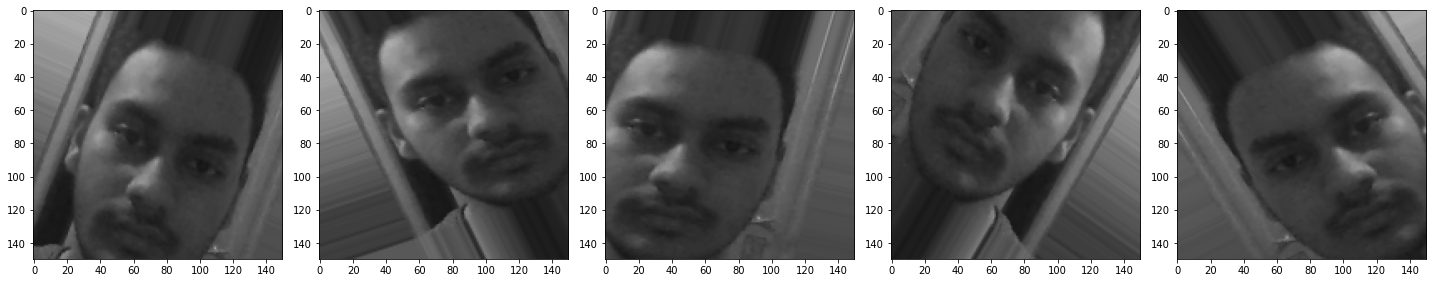

In [13]:
images = [training_data[0][0][0] for i in range(5)]
plotImages(images)

In [9]:
# save best model using vall accuracy
model_path = '/home/user/Documents/TUTORIALS/project/attendence_model.h5'
checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [10]:

#Building cnn model
cnn_model = keras.models.Sequential([
                                    keras.layers.Conv2D(filters=32, kernel_size=3, input_shape=[150, 150, 3]),
                                    keras.layers.MaxPooling2D(pool_size=(2,2)),
                                    keras.layers.Conv2D(filters=64, kernel_size=3),
                                    keras.layers.MaxPooling2D(pool_size=(2,2)),
                                    keras.layers.Conv2D(filters=128, kernel_size=3),
                                    keras.layers.MaxPooling2D(pool_size=(2,2)),                                    
                                    keras.layers.Conv2D(filters=256, kernel_size=3),
                                    keras.layers.MaxPooling2D(pool_size=(2,2)),

                                    keras.layers.Dropout(0.5),                                                                        
                                    keras.layers.Flatten(), # neural network beulding
                                    keras.layers.Dense(units=128, activation='relu'), # input layers
                                    keras.layers.Dropout(0.1),                                    
                                    keras.layers.Dense(units=256, activation='relu'),                                    
                                    keras.layers.Dropout(0.25),                                    
                                    keras.layers.Dense(units=4, activation='softmax') # output layer
])


# compile cnn model
cnn_model.compile(optimizer = Adam(lr=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [11]:
history = cnn_model.fit(training_data, 
                          epochs=50, 
                          verbose=1,
                          validation_data=valid_data,
                          callbacks=callbacks_list) 

Epoch 1/50
7/7 [==============================] - 15s 2s/step - loss: 1.2727 - accuracy: 0.3102 - val_loss: 0.8456 - val_accuracy: 0.9302

Epoch 00001: val_accuracy improved from -inf to 0.93023, saving model to /home/user/Documents/TUTORIALS/project/attendence_model.h5
Epoch 2/50
7/7 [==============================] - 13s 2s/step - loss: 0.8128 - accuracy: 0.5708 - val_loss: 0.5662 - val_accuracy: 0.9302

Epoch 00002: val_accuracy did not improve from 0.93023
Epoch 3/50
7/7 [==============================] - 13s 2s/step - loss: 0.6759 - accuracy: 0.5854 - val_loss: 0.4597 - val_accuracy: 1.0000

Epoch 00003: val_accuracy improved from 0.93023 to 1.00000, saving model to /home/user/Documents/TUTORIALS/project/attendence_model.h5
Epoch 4/50
7/7 [==============================] - 14s 2s/step - loss: 0.6545 - accuracy: 0.6841 - val_loss: 0.3369 - val_accuracy: 1.0000

Epoch 00004: val_accuracy did not improve from 1.00000
Epoch 5/50
7/7 [==============================] - 14s 2s/step - los

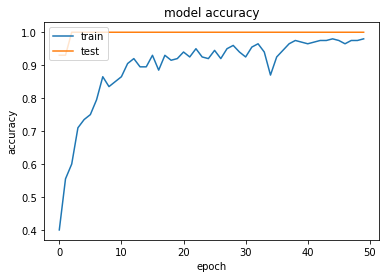

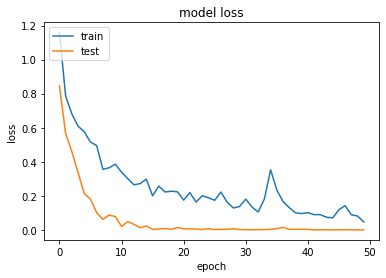

In [12]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

In [13]:
valid_data.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int32)

In [14]:
cnn_model.predict_classes(valid_data)

/home/user/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1])

In [15]:
image=cv2.imread('/home/user/Documents/TUTORIALS/project/students/train/Tanveer Shikalgar/Tanveer Shikalgar.42.jpg')


In [19]:
def detect_student():

    now = datetime.now()
    date=now.strftime("%d-%m-%Y %H-%M-%S")
    facedetect=cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    cam=cv2.VideoCapture(0)
    sampleNum=0
    path="detected_students"
    
    while(True):
        ret,img=cam.read()
        gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        faces=facedetect.detectMultiScale(gray,1.3,5)
        for (x,y,w,h) in faces:
            sampleNum+=1
            cv2.imwrite(path+"/"+date+".jpg",gray[y:y+h,x:x+w])
            cv2.rectangle(img,(x,y),(x+w,y+h),(0,0,255),2)
            cv2.waitKey(100)
        cv2.imshow("face",img)
        cv2.waitKey(1)
        if sampleNum>2:
            break;
    cam.release()
    cv2.destroyAllWindows()

    print(img.shape)
    file_path=path+"/"+date+".jpg"
    file_path="/home/user/Documents/TUTORIALS/project/detected_students/"+date+".jpg"
    print(file_path)
    model=load_model('attendence_model.h5')
    test_image = load_img(file_path, target_size = (150, 150)) # load image 
    
  
    test_image = img_to_array(test_image)/255 # convert image to np array and normalize
    test_image = np.expand_dims(test_image, axis = 0) # change dimention 3D to 4D
  
    result = model.predict(test_image).round(3) # predict student
    print('@@ Raw result = ', result)
  
    pred = np.argmax(result) # get the index of max value
    
    key_list = list(training_data.class_indices.keys())
    val_list = list(training_data.class_indices.values())
 
    # print key with val 100
    position = val_list.index(pred)
    print("label-",pred,"Student name-",key_list[position]," is present")
 
    return key_list[position]
    
student=detect_student()

(720, 1280, 3)
/home/user/Documents/TUTORIALS/project/detected_students/03-06-2021 14-03-30.jpg
@@ Raw result =  [[0.327 0.673 0.    0.   ]]
label- 1 Student name- Tanveer Shikalgar  is present


In [69]:
import pymysql as py

#connection
db=py.connect(host='localhost',user='root',password='welcome123',database='PROJECT')

#cursor
cur=db.cursor()

# query="SELECT * FROM Student_Attendence"
# cur.execute(query)
# db.commit()
# result = cur.fetchall()
# for i in result:
#     print(i)
   
# import datetime
# today = datetime.datetime.now()
# date = today.strftime("%Y-%m-%d %H:%M:%S")
# print(date)

query="INSERT INTO Student_Attendence VALUES(%s %s %s)"
val=[CURRENT_TIMESTAMP,'Suleman','Present']
cur.execute(query,val)

# # cur.execute("INSERT INTO Student_Attendence (Reporting_Time,Name,Status) VALUES(%s, %s, '%s');",(date,'Tanveer','Present')) 

db.commit()


NameError: name 'CURRENT_TIMESTAMP' is not defined